In [1]:
from jax.config import config

config.update("jax_enable_x64", True)
from dataclasses import dataclass

from jax import jit
from jax.config import config
import jax.numpy as jnp
import jax.random as jr
from typing import List
from jaxtyping import (
    Array,
    Float,
    install_import_hook,
)
from jax import vmap
import tensorflow_probability.substrates.jax.bijectors as tfb
from matplotlib import rcParams
from gpjax.base import param_field, static_field
import matplotlib.pyplot as plt
import optax as ox
import pandas as pd
import tensorflow_probability as tfp
from jaxtyping import Float, Num
from gpjax.typing import (
    Array,
    ScalarInt,
    ScalarFloat,
)
from gpjax.kernels.stationary.utils import squared_distance
with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx

# Enable Float64 for more stable matrix inversions.
key = jr.PRNGKey(123)
plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
colors = rcParams["axes.prop_cycle"].by_key()["color"]


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


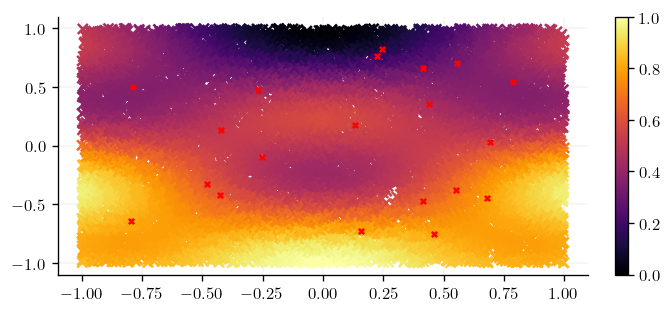

In [2]:
n = 20
d=2
noise = 1e-5

key, subkey = jr.split(key)

def branin(x):
    x_1 = x[:,0:1]
    x_2 = x[:,1:2]
    return x_1**2 - 2*x_2 + jnp.cos(3*x_1)*jnp.sin(5*x_2)


x = jr.uniform(key=key, minval=-1.0,maxval=1.0,shape=(n,d))#jr.normal(key=key, shape=(n,d))
signal = branin(x)
y = signal + jr.normal(subkey, shape=signal.shape) * noise
D = gpx.Dataset(X=x, y=y)

n_plot = 10_000
xplot = jr.uniform(key=key, minval=-1.0, maxval=1.0, shape=(n_plot,d))
yplot = branin(xplot)
plt.scatter(xplot[:,0], xplot[:,1], c=yplot)
plt.scatter(x[:,0], x[:,1], color="red", s=10.0)
plt.colorbar()

n_test = 1_000
xtest = jr.uniform(key=key, minval=-1.0, maxval=1.0, shape=(n_test,d))


In [3]:
@dataclass
class OrthogonalRBFKernel(gpx.kernels.AbstractKernel):  
    base_kernel: gpx.kernels.RBF = gpx.kernels.RBF()
    
    def __call__(self, x: Num[Array, " D"], y: Num[Array, " D"]) -> ScalarFloat:
        r"""Compute the orthogonal RBF kernel between a pair of arrays.
        WE ASSUME THAT THE INPUT DIST IS N(0,1)
        """
        k = self.base_kernel(x, y)
        return k - self.cov_x_s(x) * self.cov_x_s(y) / self.var_s()
     
    def cov_x_s(self, x: Num[Array, " D"]) -> ScalarFloat:
        l2 = self.base_kernel.lengthscale**2
        cov =  self.base_kernel.variance *jnp.sqrt(l2 / (l2 + 1.0))
        return cov*jnp.exp(-0.5 * squared_distance(self.slice_input(x), jnp.zeros_like(self.slice_input(x))) / (l2 + 1))
    
    def var_s(self) -> ScalarFloat:
        l2 = self.base_kernel.lengthscale**2
        return self.base_kernel.variance * jnp.sqrt(l2 / (l2 + 2.0))
    

        

In [17]:
from itertools import product

@dataclass
class OrthogonalAdditiveKernel(gpx.kernels.AbstractKernel): 
    base_kernel: gpx.kernels.RBF = gpx.kernels.RBF()
    max_interaction_depth: ScalarInt = static_field(1)
    bias_variance: ScalarFloat = param_field(jnp.array(1.0), bijector=tfb.Softplus()) # for constant term
    
    def __post_init__(self):
        if not self.base_kernel.active_dims:
            raise ValueError("OAK requires a base kernel with specified active dims")
        self.dim = len(self.base_kernel.active_dims)
        kernels = []
        for dim in self.base_kernel.active_dims:
            k = OrthogonalRBFKernel(base_kernel = self.base_kernel.__class__(active_dims=[dim]), active_dims=[dim])
            kernels.append(k)
        self.kernels = kernels

    def __call__(self, x: Num[Array, " D"], y: Num[Array, " D"]) -> ScalarFloat:
        r"""Compute the OAK kernel between a pair of arrays.
        WE ASSUME THAT THE INPUT DIST IS N(0,1)
        """
        ks = self.eval_kernels(x,y)
        return jnp.sum(self.compute_additive_terms_girad_newton(ks))

        # zeroth_order = self.bias_variance
        # first_order = jnp.sum(ks)
        
        # if self.max_interaction_depth==0:
        #     return zeroth_order
        # elif self.max_interaction_depth==1:
        #     return zeroth_order + first_order
        # elif self.max_interaction_depth==2:
        #     ks_pair = 0.5 * ks[:,None] * ks[None,:]
        #     second_order =  jnp.sum(ks_pair ) - 0.5 * jnp.sum(ks)
        #     return zeroth_order + first_order + second_order
            
    @jit    
    def eval_kernels(self, x,y):
        return jnp.array([k(x,y) for k in self.kernels])

    @jit   
    def compute_additive_terms_girad_newton(self, ks: Num[Array, " D"]) -> ScalarFloat:
        r"""Given a list of inputs, compute a new list containing all products up to order
        `max_interaction_depth`. For efficiency, we us the Girad Newton identity 
        (i.e. O(d^2) instead of exponential).
        """

        ks = ks[None, :] # [1, d]
        powers = jnp.arange(self.max_interaction_depth + 1)[:, None] # [p + 1, 1]
        s = jnp.power(ks,powers) # [p+1, d]
        e = jnp.zeros(shape=(self.max_interaction_depth+1), dtype=jnp.float64) 
        e = e.at[n].set(self.bias_variance) # start with constant term
        for n in range(1, self.max_interaction_depth + 1): # has to be for loop because iterative
            thing = vmap(lambda k: ((-1.0)**(k-1))*e[n-k]*s[:, k])(jnp.arange(1, n+1))
            e = e.at[n].set((1.0/n) *jnp.sum(thing))
        return jnp.array(e) # [max_interaction_depth + 1]





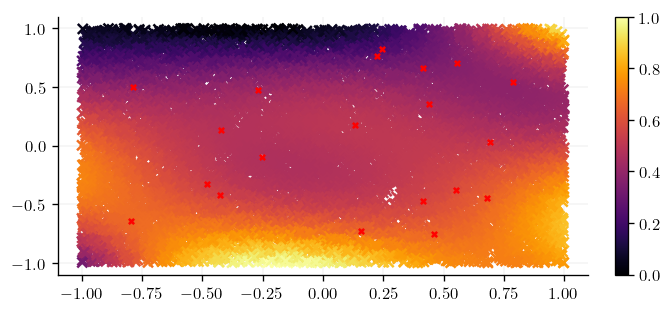

In [5]:
kernel = gpx.kernels.RBF(active_dims=[0,1])
meanf = gpx.mean_functions.Zero()
prior = gpx.Prior(mean_function=meanf, kernel=kernel)
likelihood = gpx.Gaussian(num_datapoints=D.n, obs_noise=1e-5)
posterior = prior * likelihood

mean = posterior.predict(xplot, D).mean()
plt.scatter(xplot[:,0], xplot[:,1], c=mean)
plt.scatter(x[:,0], x[:,1], color="red", s=10.0)
plt.colorbar()

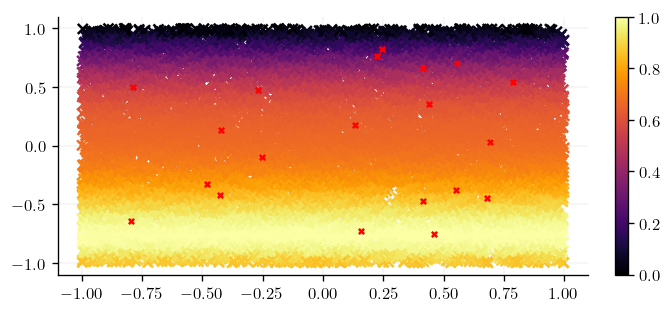

In [18]:
kernel = OrthogonalAdditiveKernel(base_kernel = gpx.kernels.RBF(active_dims=[0,1]), max_interaction_depth=1)
meanf = gpx.mean_functions.Zero()
prior = gpx.Prior(mean_function=meanf, kernel=kernel)
likelihood = gpx.Gaussian(num_datapoints=D.n, obs_noise=1e-5)
posterior = prior * likelihood

mean = posterior.predict(xplot, D).mean()
plt.scatter(xplot[:,0], xplot[:,1], c=mean)
plt.scatter(x[:,0], x[:,1], color="red", s=10.0)
plt.colorbar()

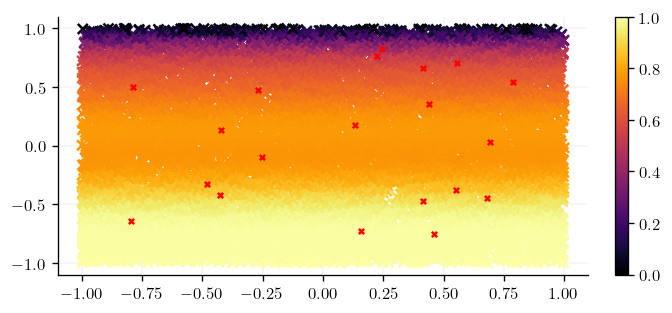

In [19]:
kernel = OrthogonalAdditiveKernel(base_kernel = gpx.kernels.RBF(active_dims=[0,1]), max_interaction_depth=2)
meanf = gpx.mean_functions.Zero()
prior = gpx.Prior(mean_function=meanf, kernel=kernel)
likelihood = gpx.Gaussian(num_datapoints=D.n, obs_noise=1e-5)
posterior = prior * likelihood

mean = posterior.predict(xplot, D).mean()
plt.scatter(xplot[:,0], xplot[:,1], c=mean)
plt.scatter(x[:,0], x[:,1], color="red", s=10.0)
plt.colorbar()

In [21]:
@dataclass
class KernelComponent(gpx.kernels.AbstractKernel): 
    oak_kernel: OrthogonalAdditiveKernel = OrthogonalAdditiveKernel(base_kernel = gpx.kernels.RBF(active_dims=[0,1]), max_interaction_depth=2)
    iComponent_list: ScalarInt = static_field([0])

    def __post_init__(self):
        self.kernels = [
            k
            for i, k in enumerate(self.oak_kernel.kernels)
            if i in self.iComponent_list
        ]
    
    def __call__(self, x: Num[Array, " D"], y: Num[Array, " D"]) -> ScalarFloat:
        r"""Compute the relevant components of the OAK kernel between a pair of arrays.
        WE ASSUME THAT THE INPUT DIST IS N(0,1)
        """
        if len(self.iComponent_list) == 0: # return bias component
            return self.oak_kernel.bias_variance
        else:
            ks = jnp.array([self.oak_kernel.bias_variance] + [k(x,y) for k in self.kernels])
            return jnp.prod(ks)

  

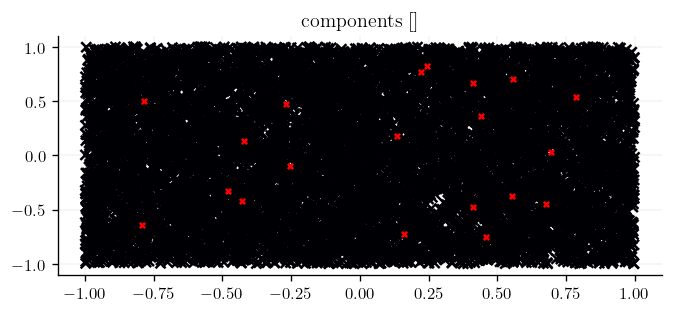

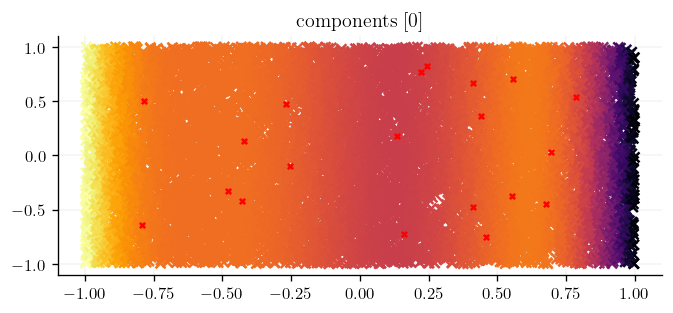

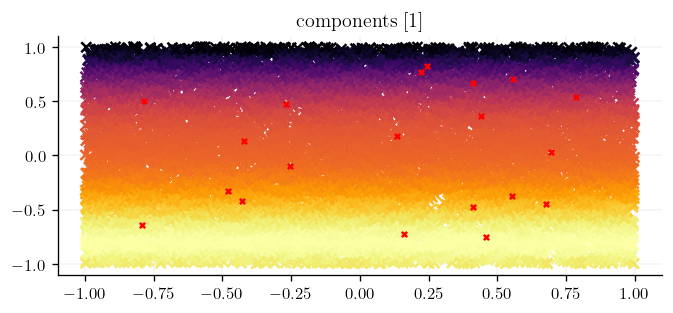

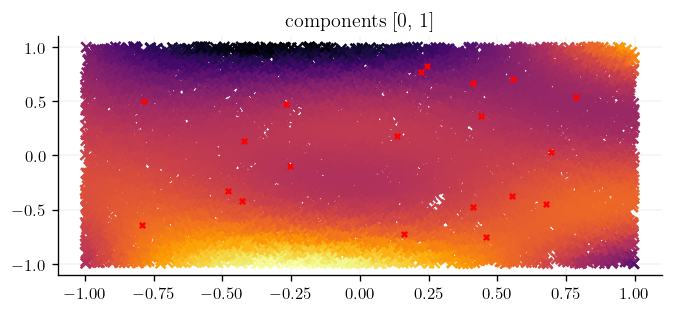

In [22]:
def plot_posterior_with_components(components):
    kernel_comp = KernelComponent(oak_kernel=kernel,iComponent_list = components)
    prior = gpx.Prior(mean_function=meanf, kernel=kernel_comp)
    likelihood = gpx.Gaussian(num_datapoints=D.n, obs_noise=1e-5)
    posterior = prior * likelihood
    mean = posterior.predict(xplot, D).mean()
    plt.figure()
    plt.scatter(xplot[:,0], xplot[:,1], c=mean)
    plt.title(f"components {components}")
    plt.scatter(x[:,0], x[:,1], color="red", s=10.0)

plot_posterior_with_components([])
plot_posterior_with_components([0])
plot_posterior_with_components([1])
plot_posterior_with_components([0,1])

In [ ]:
kernels = [gpx.kernels.RBF(), gpx.kernels.RBF()]

x = jnp.array([[1.0]])
y = jnp.array([[1.0]])

vmap(lambda k: k(x,y))(jnp.array(kernels))